In [1]:
%load_ext autoreload
%autoreload 2

# For general tuning after cuML analysis

In [2]:
import sys
sys.path.append('../')
import tokamakTK

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

pd.set_option('display.max_columns', None)
path = "../data/"

In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1


print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

23.45% of the data decreased alpha_R
76.55% of the data did not decrease alpha_R


Class distribution can be considered is skewed.

## Treatment to Categorical and Numerical Data

In [4]:
features = ['NUSTAR', 'BETASTAR', 'QCYL5', 'HYBRID', 'BT', 'ENBI', 'POHM', 'TAV', 'RHOSTAR', 'PLTH',
            'DWDIA', 'NEL', 'PFLOSS', 'KAREA', 'MEFF', 'WFICFORM', 'IP', 'PRAD', 'PICRH', 'PECRH', 
            'LIMMAT', 'TOK', 'DIVMAT', 'PREMAG' ]


DB5 = tokamakTK.clean_categorical_data(DB5)


# Needed to respectively clean each dtype
num_features = DB5[features].select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = DB5[features].select_dtypes(include=['object']).columns.tolist()


data_num = DB5[num_features+["TOK","DATE"]]
data_cat = DB5[cat_features]

data_num = tokamakTK.clean_numerical_data(data_num)

data_ = pd.concat([data_num,
                  (pd.concat([
                       DB5[["label"]], 
                       tokamakTK.encode_categorical_ohe(data_cat)
                      ], axis=1)
                  )],
                  axis=1)

In [16]:
X = data_.drop("label", axis=1)
y = data_["label"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

# Define the hyperparameter grid for Random Forest
param_grid = {
    'n_estimators':[490,500, 525],
    'max_depth':[19,20,22],
    'min_samples_split': [1, 2, 3],
#    'min_samples_leaf': [1 ,2, 3],
}

rf = RandomForestClassifier(#min_samples_split=2,
                            min_samples_leaf=1,
                            min_impurity_decrease=0.0007,
                            criterion='entropy',
                            max_features=None,
                            random_state=71,
                            n_jobs=-1,
                           )

grid_search = GridSearchCV(rf, 
                           param_grid, 
                           cv= StratifiedKFold(n_splits=10, shuffle=True, random_state=71), 
                           scoring='recall', 
                           n_jobs=1, 
                           refit=True
                          )

# Fit the GridSearchCV object to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best model from the GridSearchCV
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the best model on the entire training set
best_model.fit(X_train, y_train)


# 13:24  --  13:

/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate

RandomForestClassifier(criterion='entropy', max_depth=22, max_features=None,
                       min_impurity_decrease=0.0007, min_samples_split=3,
                       n_estimators=525, n_jobs=-1, random_state=71)

In [17]:
# Make predictions on the test set
y_pred = best_model.predict_proba(X_val)

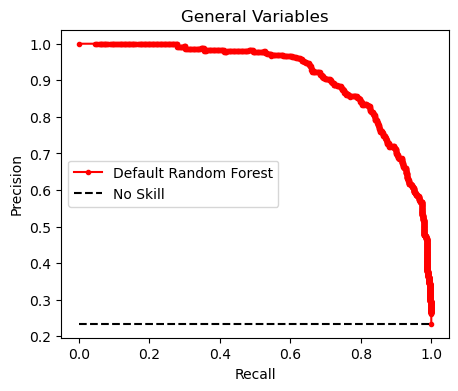

In [18]:
plt.figure(figsize=(5,4))

# keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot(recall, precision, marker='.', label='Default Random Forest', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("General Variables")
plt.legend();

In [19]:
y_pred_ = best_model.predict(X_val)
precision_recall_fscore_support(y_val, y_pred_, labels=[1,0])

(array([0.8575    , 0.93428184]),
 array([0.77954545, 0.96030641]),
 array([0.81666667, 0.94711538]),
 array([ 440, 1436]))

In [20]:
best_params

{'max_depth': 22, 'min_samples_split': 3, 'n_estimators': 525}

## [Feature Importance Based on Mean Decrease in Impurity](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

Feature importances are provided by the fitted attribute `feature_importances_` and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

**WARNING**:  Impurity-based feature importances can be misleading for high cardinality features (many unique values). See Permutation feature importance.

In [10]:
importances = best_model.feature_importances_

feature_importances = pd.DataFrame({"feature": X.columns, "importance": importances})
feature_importances = feature_importances.sort_values("importance", ascending=False).reset_index(drop=True)

print(feature_importances)

           feature  importance
0          RHOSTAR    0.172626
1              TAV    0.136451
2           NUSTAR    0.134345
3             ENBI    0.088979
4            QCYL5    0.071685
5         BETASTAR    0.048747
6             PLTH    0.045558
7             POHM    0.040477
8           PFLOSS    0.036091
9               IP    0.033652
10             NEL    0.032806
11              BT    0.032556
12           KAREA    0.032048
13            MEFF    0.027392
14           DWDIA    0.010524
15  HYBRID_UNKNOWN    0.009892
16           PICRH    0.007991
17            PRAD    0.007613
18        WFICFORM    0.006341
19           PECRH    0.003748
20         TOK_JET    0.002971
21      HYBRID_YES    0.002971
22  PREMAG_UNKNOWN    0.001565
23         TOK_AUG    0.001271
24        LIMMAT_C    0.001224
25      TOK_JETILW    0.001180
26       HYBRID_NO    0.001177
27        DIVMAT_C    0.001041
28       LIMMAT_BE    0.001032
29      PREMAG_YES    0.000855
30        DIVMAT_W    0.000817
31      

In [11]:
df = pd.DataFrame(feature_importances)
df.feature.unique()

array(['RHOSTAR', 'TAV', 'NUSTAR', 'ENBI', 'QCYL5', 'BETASTAR', 'PLTH',
       'POHM', 'PFLOSS', 'IP', 'NEL', 'BT', 'KAREA', 'MEFF', 'DWDIA',
       'HYBRID_UNKNOWN', 'PICRH', 'PRAD', 'WFICFORM', 'PECRH', 'TOK_JET',
       'HYBRID_YES', 'PREMAG_UNKNOWN', 'TOK_AUG', 'LIMMAT_C',
       'TOK_JETILW', 'HYBRID_NO', 'DIVMAT_C', 'LIMMAT_BE', 'PREMAG_YES',
       'DIVMAT_W', 'TOK_CMOD', 'DIVMAT_MO', 'LIMMAT_MO', 'PREMAG_NO',
       'DIVMAT_C/BE', 'TOK_D3D', 'TOK_AUGW', 'LIMMAT_W', 'DIVMAT_C-W',
       'LIMMAT_C-W', 'TOK_NSTX', 'TOK_JT60U', 'LIMMAT_NONE', 'TOK_START',
       'TOK_PDX', 'TOK_COMPASS', 'TOK_TFTR', 'TOK_MAST', 'DIVMAT_TI12',
       'LIMMAT_UNKNOWN', 'TOK_ASDEX', 'DIVMAT_UNKNOWN', 'TOK_PBXM',
       'DIVMAT_SS', 'DIVMAT_NONE', 'TOK_JFT2M', 'TOK_TDEV', 'TOK_TCV',
       'DIVMAT_IN'], dtype=object)

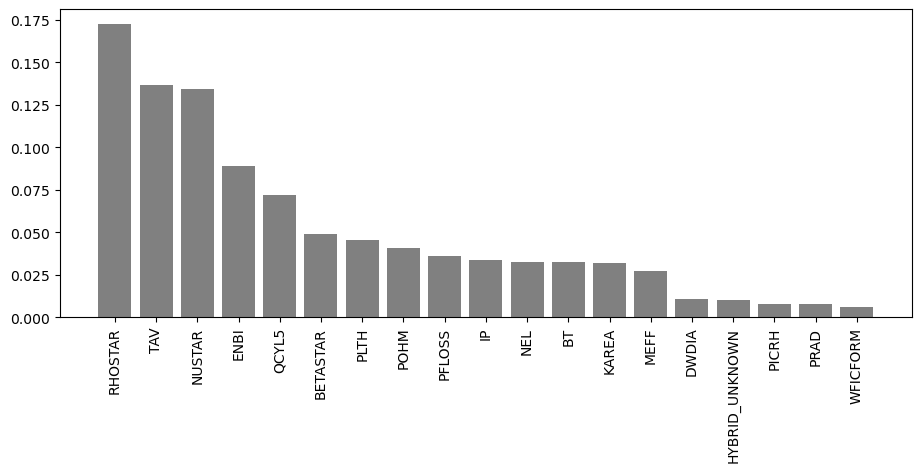

In [12]:
plt.figure(figsize=(11,4))
plt.bar(df[df.importance > 0.5e-2].feature, df[df.importance > 0.5e-2].importance, color="gray")
plt.xticks(rotation=90);

In [13]:
# Quite Important
df[df.importance > 1e-3]

,feature,importance
0,RHOSTAR,0.172626
1,TAV,0.136451
2,NUSTAR,0.134345
3,ENBI,0.088979
4,QCYL5,0.071685
5,BETASTAR,0.048747
6,PLTH,0.045558
7,POHM,0.040477
8,PFLOSS,0.036091
9,IP,0.033652


In [14]:
# Not so important
df[df.importance < 1e-3]

,feature,importance
29,PREMAG_YES,0.000855
30,DIVMAT_W,0.000817
31,TOK_CMOD,0.000751
32,DIVMAT_MO,0.000719
33,LIMMAT_MO,0.000707
34,PREMAG_NO,0.000611
35,DIVMAT_C/BE,0.000493
36,TOK_D3D,0.000295
37,TOK_AUGW,0.000258
38,LIMMAT_W,0.000196


In [15]:
df[df.importance == 0.000000]

,feature,importance
49,DIVMAT_TI12,0.0
50,LIMMAT_UNKNOWN,0.0
51,TOK_ASDEX,0.0
52,DIVMAT_UNKNOWN,0.0
53,TOK_PBXM,0.0
54,DIVMAT_SS,0.0
55,DIVMAT_NONE,0.0
56,TOK_JFT2M,0.0
57,TOK_TDEV,0.0
58,TOK_TCV,0.0
